In [51]:
import math

import librosa
import pandas
import numpy

from matplotlib import pyplot as plt
import librosa.display


In [137]:

samplerate = 16000
time_resolution = 0.050

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_fft = next_power_of_2(hop_length)

print(hop_length, n_fft)

800 1024


In [158]:
def load_annotations(path):
    df = pandas.read_csv(path, header=None)
    df.columns = ['start', 'end', 'event']
    
    # drop duplicates
    df = df[~df['start'].duplicated()]
    
    df['duration'] = df['end'] - df['start']
    df = df.sort_values('start')
    
    return df

annotations_path = 'data/annotations.csv'
annotations = load_annotations(annotations_path)
annotations.head(1)

,start,end,event,duration
0,7.055938,7.220668,yes,0.16473


In [157]:
annotations.tail(1)

,start,end,event,duration
124,299.328251,299.438071,yes,0.10982


In [178]:
annotations['end']

0        7.220668
1        7.989408
2        8.826786
3       10.858457
4       11.531104
          ...    
120    296.569023
121    297.543676
122    297.790771
123    298.367326
124    299.438071
Name: end, Length: 120, dtype: float64

0           NaN
1      0.604010
2      0.604010
3      1.825758
4      0.384370
         ...   
120    0.974653
121    0.837378
122    0.123547
123    0.453007
124    0.960925
Length: 120, dtype: float64

<AxesSubplot:>

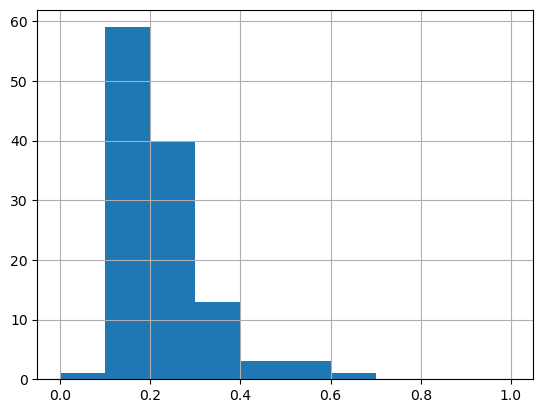

In [168]:
annotations.duration.hist(width=0.10, range=(0, 1.0))

<AxesSubplot:>

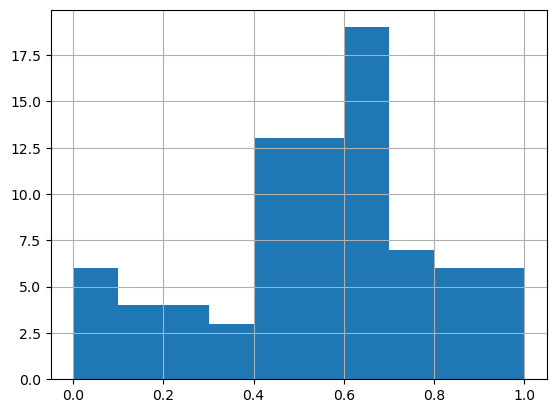

In [186]:
(annotations['start'] - (annotations['end'].shift(1))).hist(width=0.1, range=(0, 1.0))


In [198]:
def load_spectrogram(path, sr=16000, n_mels=32, n_fft=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    db = librosa.power_to_db(S, ref=0.0)
    
    return db

audio_path = 'data/source2.wav'
spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
spec.shape

(32, 6001)

In [199]:
def spectrogram_labels(events, spec, time_resolution):
    """
    Create a continious vector for the event labels that matches the time format of our spectrogram
    
    Assumes that no annotated event means nothing occurred.
    """

    freq = pandas.Timedelta(seconds=time_resolution)
    
    # Create empty covering entire spectrogram
    spec_duration = spec.shape[1] * time_resolution
    ix = pandas.timedelta_range(start=pandas.Timedelta(seconds=0.0),
                    end=pandas.Timedelta(seconds=spec_duration),
                    freq=freq,
                    closed='left',
    )
    ix.name = 'time'
    df = pandas.DataFrame({}, index=ix)
    assert len(df) == spec.shape[1], (len(df), spec.shape[1])
    df["event"] = 0
    
    # fill in event data
    for start, end in zip(events['start'], events['end']):
        s = pandas.Timedelta(start, unit='s')
        e = pandas.Timedelta(end, unit='s')
        match = df.loc[s:e]
        df.loc[s:e, "event"] = 1
    
    return df

l = spectrogram_labels(annotations[annotations.event == 'yes'], spec, time_resolution)
l

,event
time,
0 days 00:00:00,0
0 days 00:00:00.050000,0
0 days 00:00:00.100000,0
0 days 00:00:00.150000,0
0 days 00:00:00.200000,0
...,...
0 days 00:04:59.800000,0
0 days 00:04:59.850000,0
0 days 00:04:59.900000,0


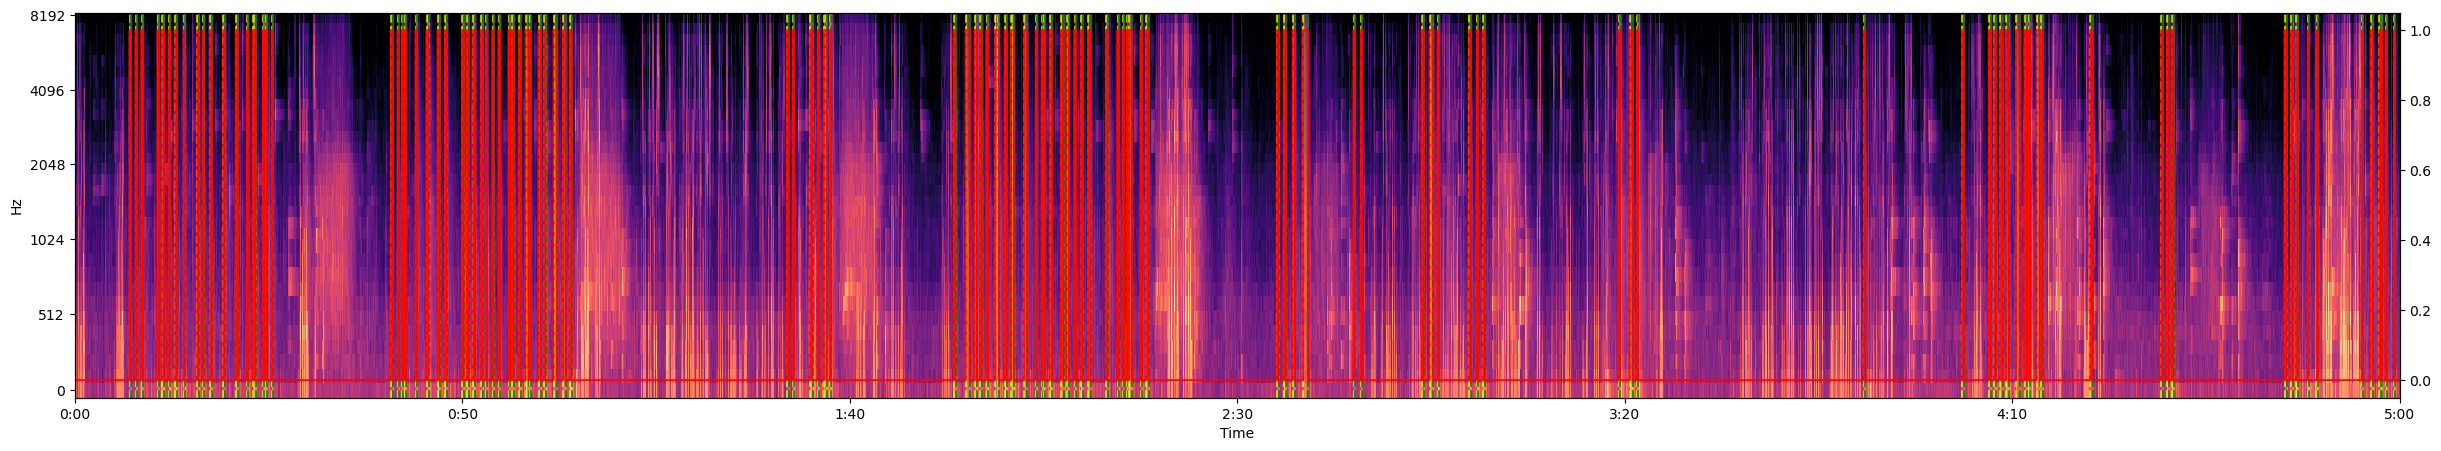

In [416]:
def plot_spectrogram(ax, spec, events=None, label_activations=None, predictions=None):

    librosa.display.specshow(ax=ax, data=spec, hop_length=hop_length, x_axis='time', y_axis='mel', sr=samplerate)

    lw = 1.5
    
    if events is not None:
        for start, end in zip(events.start, events.end):
            ax.axvspan(start, end, alpha=0.2, color='yellow')
            ax.axvline(start, alpha=0.7, color='yellow', ls='--', lw=lw)
            ax.axvline(end, alpha=0.8, color='green', ls='--', lw=lw)

    label_ax = ax.twinx()
                
    if label_activations is not None:
        a = label_activations.reset_index()
        a['time'] = a['time'].dt.total_seconds()
        label_ax.step(a['time'], a['event'], color='red', alpha=0.9)
         
    if predictions is not None:
        p = predictions.reset_index()
        p['time'] = p['time'].dt.total_seconds()
        label_ax.step(p['time'], p['probability'], color='blue', alpha=0.9)
            
        label_ax.axhline(0.5, ls='--', color='black', alpha=0.5)
            
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
#ax.set_xlim(10, 15)

(0.0, 15.0)

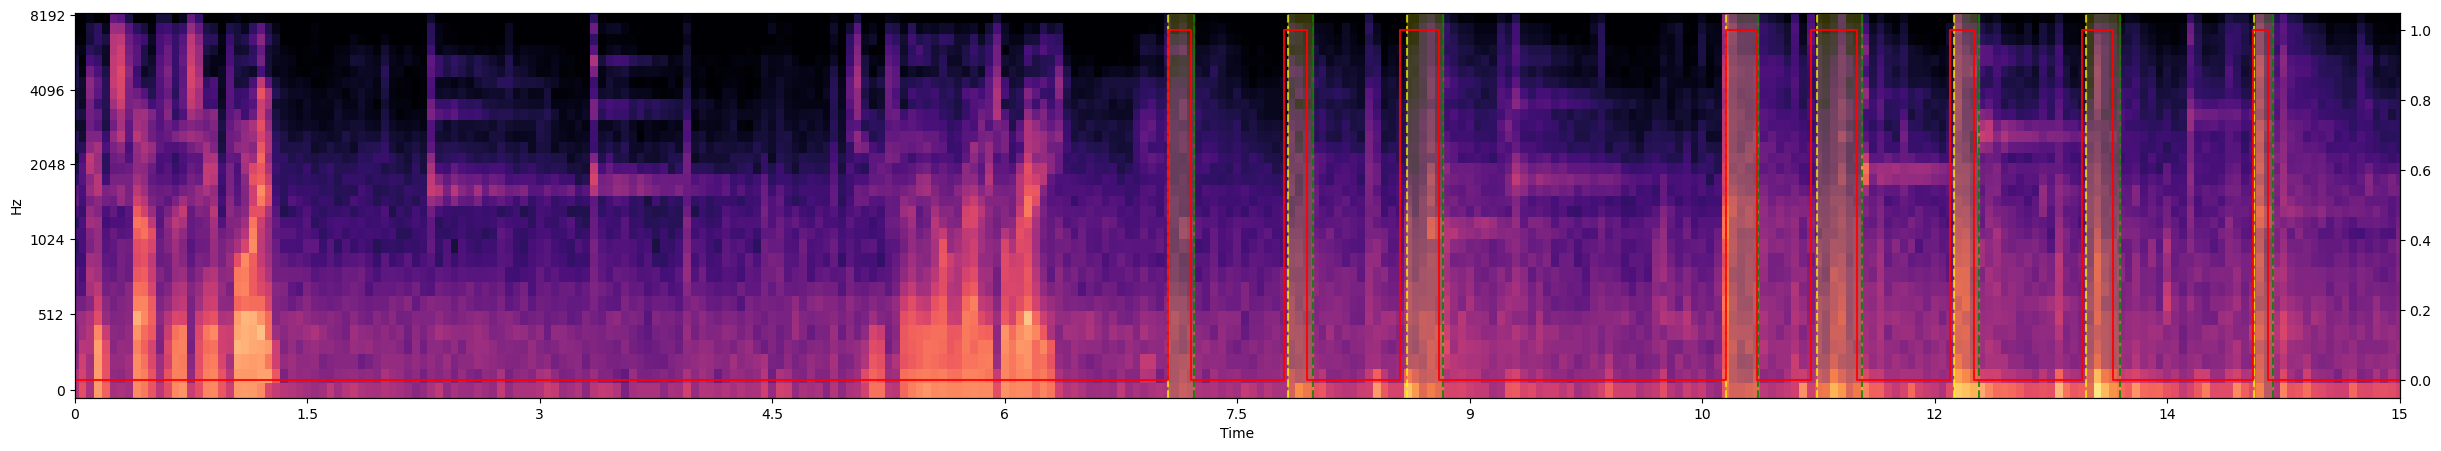

In [201]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(0, 15)
#ax.set_xlim(110, 120)

In [202]:
window_duration = 0.4
window_length = int(window_duration / time_resolution)
window_length

8

In [379]:
# extract time-windows for spectrograms and labels

def compute_windows(arr, frames, pad_value=0.0, overlap=0.5, step=None):
    if step is None:
        step = int(frames * (1-overlap))
        
    windows = []
    
    width, length = arr.shape
    
    for start_idx in range(0, length, step):
        end_idx = min(start_idx + frames, length)

        # create emmpty
        win = numpy.full((width, frames), pad_value, dtype=float)
        # fill with data
        win[:, 0:end_idx-start_idx] = arr[:,start_idx:end_idx]

        windows.append(win)

    return windows

windows = pandas.DataFrame({
    'spectrogram': compute_windows(spec, frames=window_length, overlap=0.8),
    'labels': compute_windows(l.values.T, frames=window_length, overlap=0.8),
})
windows.shape

(6001, 2)

In [356]:
# split windows into train, val, test
# note: random splitting has data leak. Much better to split by match!

def dataset_split_random(data, val_size=0.25, test_size=0.25, random_state=3, column='split'):
    """
    Split DataFrame into 3 non-overlapping parts: train,val,test
    with specified proportions
    
    Returns a new DataFrame with the rows marked by the assigned split in @column
    """
    train_size = (1.0 - val_size - test_size)
    from sklearn.model_selection import train_test_split
    
    train_val_idx, test_idx = train_test_split(data.index, test_size=test_size, random_state=random_state)
    val_ratio = (val_size / (val_size+train_size))
    train_idx, val_idx = train_test_split(train_val_idx, test_size=val_ratio, random_state=random_state)

    data = data.copy()
    data.loc[train_idx, column] = 'train'
    data.loc[val_idx, column] = 'val'
    data.loc[test_idx, column] = 'test'
    
    return data

dataset = dataset_split_random(windows, val_size=0.2, test_size=0.2)
dataset.split.value_counts()

train    3600
test     1201
val      1200
Name: split, dtype: int64

In [402]:
# build simple CNN model

import tensorflow.keras

def build_model(input_shape, dropout=0.5, lr=0.01):
    
    from tensorflow.keras.layers import Convolution2D, SeparableConv2D, Flatten, Dense, Activation, Dropout
    
    model = tensorflow.keras.Sequential([
        Convolution2D(8, 3, strides=(2,2), padding='same', input_shape=input_shape),
        SeparableConv2D(16, 3, strides=(2,2), padding='same'),
        SeparableConv2D(16, 3, strides=(2,2), padding='same'),
        Flatten(),
        Dense(32),
        Dropout(dropout),
        Activation('relu'),
        Dropout(dropout),
        Dense(16),
        Activation('relu'),
        Dropout(dropout),
        Dense(16),
        Activation('relu'),
        Dense(1, activation='sigmoid'),
    ])
   
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    # Focal loss tends to be a bit better for imbalanced data
    loss = tensorflow.keras.losses.BinaryFocalCrossentropy()
    
    #loss = tensorflow.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(32, window_length, 1))
model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 16, 4, 8)          80        
                                                                 
 separable_conv2d_98 (Separa  (None, 8, 2, 16)         216       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_99 (Separa  (None, 4, 1, 16)         416       
 bleConv2D)                                                      
                                                                 
 flatten_74 (Flatten)        (None, 64)                0         
                                                                 
 dense_243 (Dense)           (None, 32)                2080      
                                                                 
 dropout_169 (Dropout)       (None, 32)              

In [403]:
tt = get_XY(split='train')
                   
                   
tt[0][numpy.squeeze(tt[1])].shape

(770, 32, 8, 1)

In [404]:
tt[0][numpy.squeeze(tt[1]) == False].shape

(2830, 32, 8, 1)

In [405]:
# train. 

epochs = 200
batch_size = 32

def get_XY(split):
    d = dataset[dataset.split == split]
    X = numpy.expand_dims(numpy.stack(d.spectrogram), -1)
    Y = numpy.stack(d.labels)
    Y = numpy.any(Y, axis=-1)
    #Y = numpy.count_nonzero(Y, axis=-1) >= 2
    #print(X.shape)
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_pr_auc', patience=20)

model = build_model(input_shape=(32, window_length, 1), dropout=0.20, lr=2*0.01)
hist = model.fit(x=train[0], y=train[1],
          validation_data=val,
          epochs=epochs,
          batch_size=batch_size,
        callbacks=[early_stop],
)


Epoch 1/200
113/113 [==============================] - 1s 4ms/step - loss: 0.1551 - pr_auc: 0.2054 - precision: 0.1957 - recall: 0.0584 - val_loss: 0.1504 - val_pr_auc: 0.1628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1397 - pr_auc: 0.2104 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1421 - val_pr_auc: 0.1964 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1368 - pr_auc: 0.2191 - precision: 0.2500 - recall: 0.0013 - val_loss: 0.1364 - val_pr_auc: 0.2209 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
113/113 [==============================] - 0s 2ms/step - loss: 0.1360 - pr_auc: 0.2176 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1368 - val_pr_auc: 0.2670 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
113/113 [==============================] - 0s 2ms/step -

<AxesSubplot:xlabel='epoch'>

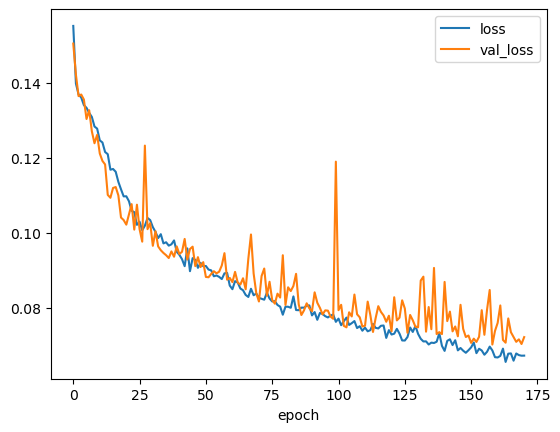

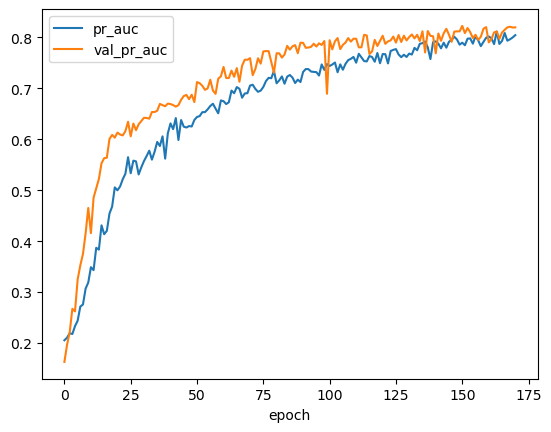

In [407]:
# Plot the scores over epochs
history = pandas.DataFrame(hist.history)
history.index.name = 'epoch'
history.plot(y=['loss', 'val_loss'])
history.plot(y=['pr_auc', 'val_pr_auc'])

In [417]:
test = get_XY(split='test')

results = pandas.DataFrame({
    'split': [ 'test', 'train', 'val' ],
})
def get_metric(split):
    X, Y = get_XY(split=split)
    r = model.evaluate(x=X, y=Y, return_dict=True)
    return pandas.Series(r)

e = results.split.apply(get_metric)
results = pandas.merge(results, e, right_index=True, left_index=True).set_index('split')
results


38/38 [==============================] - 0s 1ms/step - loss: 0.0721 - pr_auc: 0.8198 - precision: 0.6825 - recall: 0.8052    


,loss,pr_auc,precision,recall
split,,,,
test,0.064983,0.865779,0.714286,0.854545
train,0.060049,0.862146,0.741676,0.838961
val,0.072112,0.819790,0.682540,0.805243


38/38 [==============================] - 0s 707us/step


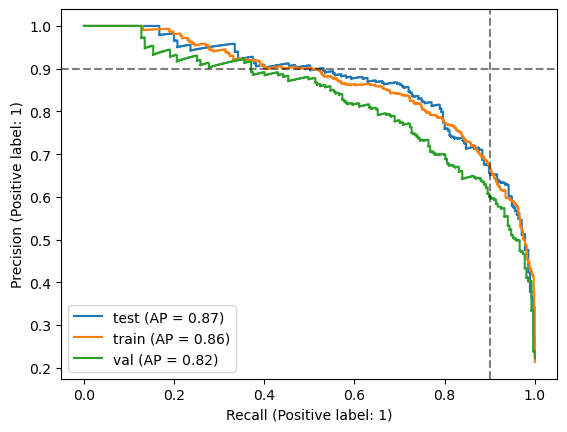

In [418]:
# Plot precision/recall trade-off

from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1)

for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = Y
    y_pred = model.predict(X)
    
    #pandas.Series(numpy.squeeze(y_pred)).hist()

    PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y_true, y_pred=y_pred, name=split)

ax.axhline(0.9, ls='--', color='black', alpha=0.5)
ax.axvline(0.9, ls='--', color='black', alpha=0.5)

188/188 [==============================] - 0s 663us/step
0 days 00:05:00.250000
(6001,) (6001,) 6001 None


(0.0, 25.0)

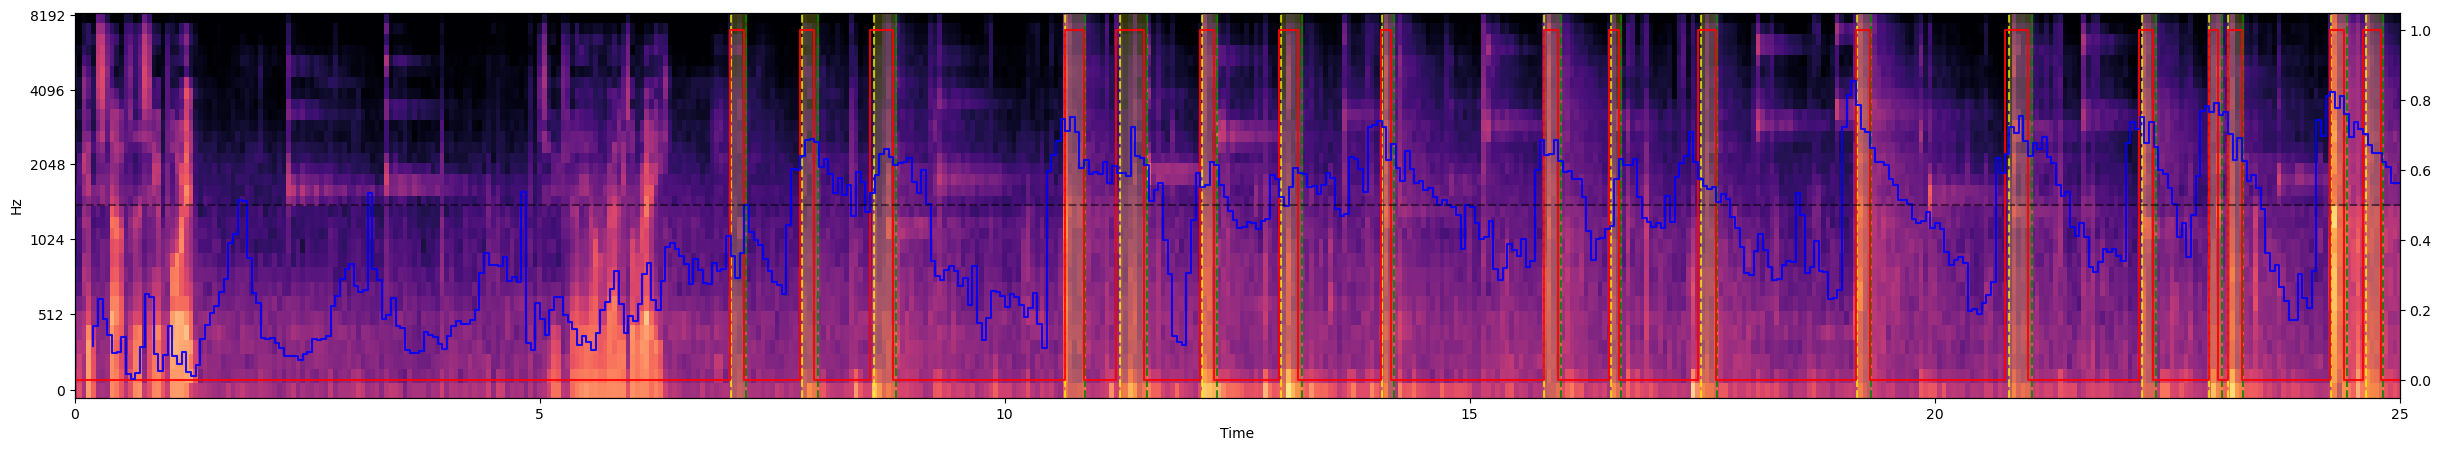

In [420]:

def predict_spectrogram(model, spec):
    
    wins = compute_windows(spec, frames=window_length, step=1)
    t = numpy.linspace(0.0, (spec.shape[1]/window_length)*window_duration, len(wins))
    X = numpy.expand_dims(numpy.stack(wins), -1)
    y = numpy.squeeze(model.predict(X))
    
    t += (window_duration*0.5)
    
    t = pandas.to_timedelta(t, unit='s')
    
    print(t.shape, y.shape, len(wins), print(t[-1]))
    
    df = pandas.DataFrame({
        'time': t,
        'probability': y,
    })
    return df
    
predictions = predict_spectrogram(model, spec)
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)
ax.set_xlim(0, 25)

